Current Time = 08:58:55

************************************************************
use_gpu = 1, use_hash=1, use_thread = 0


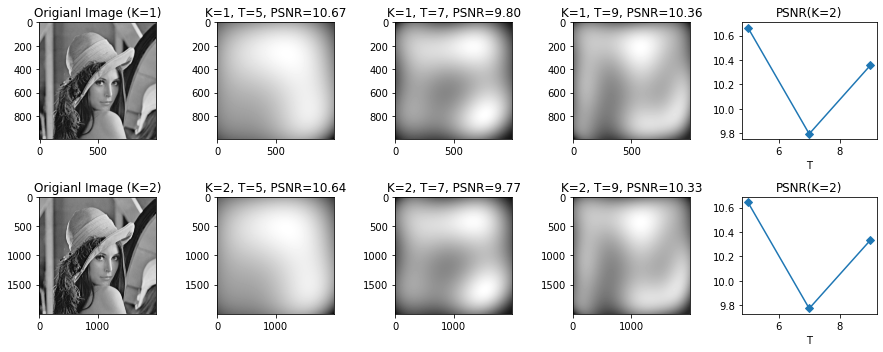


Done.
Wall time: 9.45 s


In [15]:
%%time

from IPython.display import clear_output
clear_output()

# 저니크 모멘트 계산 

from AZernike import *

# 차수에 따른 연산 속도 

print_curr_time()

def test_moment_restore(img_infos, img_input, Ks, Ts, **options) :
    print( line2 )
    print( f"use_gpu = { options['use_gpu'] }, use_hash={ options['use_hash'] }, use_thread = { options['use_thread'] }" )
    
    use_gpu = get_option( "use_gpu", **options )

    for K in Ks : 
        options[ "hash" ] = {}

        circle_type = "outer"

        rho, theta, x, y, dx, dy, k, area = rho_theta( 1000*K, circle_type, **options ) 

        img = cv.resize( img_input, (int(K*1_000), int(K*1_000)), interpolation=cv.INTER_AREA )
        
        np = cupy if use_gpu else numpy
        
        if use_gpu :
            img = cupy.asarray( img )
        pass

        # image scaled
        img_infos.append( { "title" : f"Origianl Image (K={K})", "img" : img, "K" : K } )

        for T in Ts : 

            moments, _ = calc_moments(T, img, rho, theta, dx, dy, **options )
            img_restored, run_time = restore_image(moments, rho, theta, **options )
            
            t_img = img_restored.real
            psnr = calc_psnr( img, t_img, **options )
            img_infos.append( { "title" : f"K={K}, T={T}, PSNR={psnr:.2f}", "img" : t_img, "psnr" : psnr, "K" : K, "T" : T, "rum_time" : run_time } ) 
        pass
        
        if "hash" in options : 
            del options[ "hash" ]
        pass
    pass
pass # test_moment_restore

def plot_moment_restore(img_infos, Ks, Ts ) :
    # 서브 챠트 생성 
    col_cnt = len(Ks) if len(Ks) > len(Ts) else len(Ts)
    col_cnt += 2 

    if col_cnt > 7 :
        col_cnt = 7 

    row_cnt = len( img_infos ) // col_cnt
    if col_cnt*row_cnt < len( img_infos ) :
        row_cnt += 1
    pass

    w = 2.5
    fig, charts = plt.subplots( row_cnt, col_cnt, figsize=(w*col_cnt, w*row_cnt) )
    charts = charts.ravel() if row_cnt*col_cnt > 1 else [charts]
    chart_idx = 0 

    K_prev = None 
    psnrs = []
    K = None
    
    for img_info in img_infos : 
        t_img = img_info[ "img" ]
        title = img_info[ "title" ]
        
        K = img_info[ "K" ]        
        
        if K_prev is not None and K != K_prev : 
            chart = charts[ chart_idx ] ; chart_idx += 1
            
            chart.plot( Ts, psnrs, marker="D", label=f"PSNR(K={K})" )
            
            chart.set_title( f"PSNR(K={K})" )
            chart.set_xlabel( f"T" )
            
            psnrs = []
        pass
    
        if "psnr" in img_info : 
            psnr = img_info[ "psnr"]
            psnrs.append( psnr )
        pass
            
        colorbar = False 
        if "colorbar" in img_info :
            colorbar = img_info[ "colorbar" ]

        chart = charts[ chart_idx ] ; chart_idx += 1
        
        chart.set_title( title )
        
        pos = chart.imshow( cupy.asnumpy( t_img ) if options["use_gpu"] else t_img, cmap='gray' )
        colorbar and fig.colorbar(pos, ax=chart) 
        
        K_prev = K
    pass

    if K is not None and len(Ks) > 0 and len( psnrs ) > 0 : 
        chart = charts[ chart_idx ] ; chart_idx += 1
        
        chart.plot( Ts, psnrs, marker="D", label=f"PSNR(K={K})" )
        
        chart.set_title( f"PSNR(K={K})" )
        chart.set_xlabel( f"T" )
        
        psnrs = []
    pass

    # draw empty chart
    for chart_idx in range( chart_idx, len(charts) ) :
        chart = charts[ chart_idx ]
        chart.plot( [0,0], [0,0] )
        chart.set_axis_off()
    pass

    plt.tight_layout(); plt.show() 
pass

options = {}
options[ "debug" ] = 0 
options[ "use_gpu" ] = 1
options[ "hash" ] = {}
options[ "use_hash" ] = 1  
options[ "use_thread"] = 0 

img_infos = []
    
Ks = numpy.arange( 1, 3, 1 )
Ts = numpy.arange( 5, 11, 2 )

img = cv.imread( 'image/lenna.png', 0 )
        
test_moment_restore( img_infos, img, Ks, Ts, **options )
plot_moment_restore( img_infos, Ks, Ts )

print( "\nDone." )

In [18]:
options = {}
options[ "debug" ] = 0 
options[ "use_gpu" ] = 1
options[ "hash" ] = {}
options[ "use_hash" ] = 1  
options[ "use_thread"] = 0 

img_infos = []
    
Ks = numpy.arange( 2, 3, 1 )
Ts = numpy.arange( 5, 21, 3 )

img = cv.imread( 'image/lenna.png', 0 )
        
test_moment_restore( img_infos, img, Ks, Ts, **options )
plot_moment_restore( img_infos, Ks, Ts )

print( "\nDone." )


************************************************************
use_gpu = 1, use_hash=1, use_thread = 0


KeyboardInterrupt: 